# Latent Semantic Analysis (LSA)

# Crawling Data Pta Trunojoyo

sebelum melakukan proses crawling data, pastikan anda sudah menginstall library Scrapy dari python. Jika anda belum menginstall Scrapy anda dapat menginstall nya dengan cara ketikkan "pip install Scrapy" pada cmd

## Crawling pertama

pada proses crawling yang pertama ini, kita akan mengambil link yang ada pada halaman kumpulan judul pta. cara untuk melakukan crawling adalah:
1. buat file python (.py) misalkan "pta_trunojoyo.py".
2. copy paste code yang ada dibawah ini. (anda dapat memodifikasi kode ini sesuai dengan link pta yang anda inginkan).
3. jalankan file "pta_trunojoyo.py" dengan cara mengetikkan "scrapy runspider pta_trunojoyo.py -O link_pta.csv" , untuk yang bagian "link_pta.csv" ini merupakan output file yang anda crawling, karena disini saya menggunakan contoh "link_pta.csv" maka hasil outputnya dalam bentuk file csv.

In [1]:
import scrapy


class QuotesSpider(scrapy.Spider):
    name = "quotes"

    def start_requests(self):

        arrayData = ['https://pta.trunojoyo.ac.id/c_search/byprod/7']
        for i in range(2, 12):
            inArray = 'https://pta.trunojoyo.ac.id/c_search/byprod/7/' + str(i)
            arrayData.append(inArray)
        for url in arrayData:
            yield scrapy.Request(url=url, callback=self.parse)

    def parse(self, response):
        for i in range(1,6):
            yield {
                'link': response.css('#content_journal > ul > li:nth-child(' + str(i) + ') > div:nth-child(3) > a::attr(href)').extract()
            }

## Crawling kedua

Untuk proses crawling yang kedua ini, saya mengambil link website pta hasil dari crawling pertama yang sudah di export dalam bentuk csv. untuk membaca file csv ini saya menggunakan library pandas. lalu setelah file dibaca, saya masukkan kedalam array. setelah itu masing masing link akan dilakukan proses crawling.
Pada proses cawling kedua ini kita akan menuju website pta nya langsung, untuk mendapatkan data judul, label dan isi dari masing-masing pta.
jalankan file ini dengan cara yang sama seperti yang pertama, akan tetapi sesuaikan nama filenya. cnothnya seperti "scrapy runspider pta_trunojoyo_data.py -O data_pta.csv"

In [2]:
import scrapy
import pandas as pd



class QuotesSpider(scrapy.Spider):
    name = "quotes"

    def start_requests(self):
        
        dataCSV = pd.read_csv('link_pta.csv')
        indexData = dataCSV.iloc[:, [0]].values
        arrayData = []
        for i in indexData:
            ambil = i[0]
            arrayData.append(ambil)
        for url in arrayData:
            yield scrapy.Request(url=url, callback=self.parse)

    def parse(self, response):
        yield {
            'judul': response.css('#content_journal > ul > li > div:nth-child(2) > a::text').extract(),
            'penulis': response.css('#content_journal > ul > li > div:nth-child(2) > div:nth-child(2) > span::text').extract(),
            'dosen_1': response.css('#content_journal > ul > li > div:nth-child(2) > div:nth-child(3) > span::text').extract(),
            'dosen_2': response.css('#content_journal > ul > li > div:nth-child(2) > div:nth-child(4) > span::text').extract(),
            'abstrak_ID': response.css('#content_journal > ul > li > div:nth-child(4) > div:nth-child(2) > p::text').extract(),
            'abstrak_EN': response.css('#content_journal > ul > li > div:nth-child(4) > div:nth-child(4) > p::text').extract(),
            
        }

# Latent Semantic Analysis (LSA)

sebelum kita berpindah ke LSA, ada beberapa hal yang perlu dipersiapkan terlebih dahulu.
beberapa library yang perlu di siapkan yaitu nltk, pandas, numpy dan scikit-learn.
jika anda menggunakan google colab anda bisa mengetikan syntax dibawah ini untuk melakukan instalasi library yang dibutuhkan.

!pip install nltk <br>
!pip install pandas <br>
!pip install numpy <br>
!pip install scikit-learn <br>
!pip install sastrawi <br>

dan juga pastikan mengetikkan syntax dibawah ini untuk mendownload tambahan library dari nltk

import nltk<br>
nltk.download('popular')

## preprocessing data

### import libray

import library yang dibutuhkan untuk preprocessing data

In [3]:
# import library
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import numpy as np

export file "data_pta.csv" dalam bentuk data frame pandas.

In [4]:
#import data frame
dataCSV = pd.read_csv('data_pta.csv')
dataCSV = dataCSV.drop(columns=['penulis', 'dosen_1','dosen_2', 'abstrak_EN'], axis=1)
dataCSV.head()

,judul,abstrak_ID
0,PENGARUH RELATIONSHIP MARKETING TERHADAP LOYAL...,Tujuan penelitian ini adalah untuk mengetahui ...
1,PENGARUH SELF EFFICACY TERHADAP PRESTASI AKADE...,Tujuan dari penelitian ini adalah untuk menget...
2,ANALISIS PERSEPSI BRAND ASSOCIATION MENURUT PE...,Tujuan penelitian ini adalah untuk mengetahui ...
3,Pengukuran Website Quality Pada Situs Sistem A...,Aplikasi nyata pemanfaatan teknologi informasi...
4,PENGARUH STRUKTUR MODAL DAN LIKUIDITAS TERHADA...,Pendekatan penelitian yang digunakan dalam pen...


## cek missing value

cek missing value, dengan isna()

In [5]:
dataCSV.isna().sum()

judul         0
abstrak_ID    1
dtype: int64

hapus baris yang mengandung missing value, dengan fungsi pandas dropna()

In [6]:
dataCSV = dataCSV.dropna(axis=0, how='any')

cek lagi missing valuenya setelah di hapus kolom yang mengandung missing valuenya

In [7]:
dataCSV.isna().sum()

judul         0
abstrak_ID    0
dtype: int64

### Cleansing dan Stopword
disini kita melakukan cleansing data, yang artinya kita membersihkan data dari simbol, angka dan spasi. <br>
lalu untuk stopword ini untuk membuang kata yang tidak mempunyai makna seperti:
1. "dan"
2. "yang" 
3. "atau"
4. "adalah"

In [8]:
index_iloc = 0
len_df = len(dataCSV.index)
array_stopwords = []
for kata in range(len_df):
    # indexData itu ambil tiap bagian dari data frame dengan nama dataCSV
    indexData = dataCSV.iloc[index_iloc, [1]].values
    clean_words = [w for w in word_tokenize(indexData[0].lower())
                                    if w.isalpha()
                                    and w not in stopwords.words('indonesian')]
    
    array_stopwords.append(clean_words)
    index_iloc += 1

# membuat kata-kata 1 dokumen di list yang sama
NewArray_stopwords = []
for j in array_stopwords:
    # proses stem per kalimat
    temp = ""
    for i in j:
        # print(i)
        temp = temp +" "+ i

    NewArray_stopwords.append(temp)
print(NewArray_stopwords[0])

 tujuan penelitian pengaruh variabel relationship marketing keuntungan komitmen komunikasi kebenaran loyalitas nasabah adira finance variabel relationship marketing berpengaruh loyalitas nasabah adira finance wilayah surabaya barat berdasarkan uji f variabel relationship marketing keuntungan komitmen komunikasi kebenaran simultan berpengaruh signifikan loyalitas nasabah adira finance wilayah surabaya barat berdasarkan uji t parsial variabel keuntungan komitmen kebenaran berpengaruh signifikan variabel terikat variabel komunikasi berpengaruh negatif variabel terikat variabel berpengaruh variabel komitmen kunci relationship marketing keuntungan komitmen komunikasi kebenaran loyalitas


diatas ini adalah contoh isi dari salah satu berita yang sudah dilakukan cleansing dan stopword.

dibawah ini adalah proses memasukkan data yang sudah dilakukan preprocessing ke dalam data frame yang mempunyai nama "dataSCV"

In [9]:
dataCSV.head()

,judul,abstrak_ID
0,PENGARUH RELATIONSHIP MARKETING TERHADAP LOYAL...,Tujuan penelitian ini adalah untuk mengetahui ...
1,PENGARUH SELF EFFICACY TERHADAP PRESTASI AKADE...,Tujuan dari penelitian ini adalah untuk menget...
2,ANALISIS PERSEPSI BRAND ASSOCIATION MENURUT PE...,Tujuan penelitian ini adalah untuk mengetahui ...
3,Pengukuran Website Quality Pada Situs Sistem A...,Aplikasi nyata pemanfaatan teknologi informasi...
4,PENGARUH STRUKTUR MODAL DAN LIKUIDITAS TERHADA...,Pendekatan penelitian yang digunakan dalam pen...


In [10]:
dataCSV = dataCSV.drop('judul', axis=1)
dataCSV = dataCSV.drop('abstrak_ID', axis=1)
dataCSV['isi'] = np.array(NewArray_stopwords)
dataCSV.head()

,isi
0,tujuan penelitian pengaruh variabel relations...
1,tujuan penelitian pengaruh variabel self effi...
2,tujuan penelitian persepsi brand association ...
3,aplikasi nyata pemanfaatan teknologi informas...
4,pendekatan penelitian penelitian pendekatan k...


## Term Frequency - Inverse Document Frequency (TF-IDF)

setelah melakukan pre-processing data, selanjutnya dilakukan proses TF-IDF <br>
TF-IDF adalah suatu metode algoritma untuk menghitung bobot setiap kata di setiap dokumen dalam korpus. Metode ini juga terkenal efisien, mudah dan memiliki hasil yang akurat. <br>
Term Frequency (TF) merupakan jumlah kemunculan kata pada setiap dokumen. dirumuskan dengan jumlah frekuensi kata terpilih / jumlah kata <br>
Inverse Document Matrix (IDF) dirumuskan dengan log((jumlah dokumen / jumlah frekuensi kata terpilih). <br>
untuk menghasilkan TF-IDF maka hasil dari TF dikalikan dengan IDF, seperti rumus dibawah ini:

$$
W_{i, j}=\frac{n_{i, j}}{\sum_{j=1}^{p} n_{j, i}} \log _{2} \frac{D}{d_{j}}
$$

Dengan:

$
{W_{i, j}}\quad\quad\>: \text { pembobotan tf-idf untuk term ke-j pada dokumen ke-i } \\
{n_{i, j}}\quad\quad\>\>: \text { jumlah kemunculan term ke-j pada dokumen ke-i }\\
{p} \quad\quad\quad\>\>: \text { banyaknya term yang terbentuk }\\
{\sum_{j=1}^{p} n_{j, i}}: \text { jumlah kemunculan seluruh term pada dokumen ke-i }\\
{d_{j}} \quad\quad\quad: \text { banyaknya dokumen yang mengandung term ke-j }\\
$



### import Library TF-IDF

import library yang dibutuhkan dalam melakukan pemrosesan TF-IDF dan juga ambil data dari data hasil preprocessing yang sudah dilakukan diatas.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
df = dataCSV

### Term Frequency

ubah data menjadi bentuk list, lalu lakukan proses tf dengan cara memanggil library CountVectorizer dari scikit-learn.

In [12]:
#mengubah fitur dalam bentuk list
list_isi_berita = []
for i in range(len(df.iloc[:, -1])):
    list_isi_berita.append(df.iloc[i, -1])

# proses term frequency
count_vectorizer = CountVectorizer(min_df=1)
tf = count_vectorizer.fit_transform(list_isi_berita)

#get fitur
fitur = count_vectorizer.get_feature_names_out()

# menampilkan data TF
show_tf = count_vectorizer.fit_transform(list_isi_berita).toarray()
df_tf =pd.DataFrame(data=show_tf,index=list(range(1, len(show_tf[:,1])+1, )),columns=[fitur])
df_tf = df_tf.T

df_tf.head(8)

,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
abidin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abstrak,0,0,0,0,0,1,0,1,1,1,...,1,1,1,0,1,1,1,0,0,0
abtrak,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
accidental,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
acer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
action,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
adaro,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
adira,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF

setelah melakukan proses TF, lakukan proses TF-IDF dan kemudian simpan hasilnya dalam bentuk data frame.

In [13]:
#tfidf dengan tfidf transformer
tfidf_transform = TfidfTransformer(use_idf=True,norm='l2',smooth_idf=True)
tfidf=tfidf_transform.fit_transform(count_vectorizer.fit_transform(list_isi_berita)).toarray()
df_tfidf =pd.DataFrame(data=tfidf,index=list(range(1, len(tfidf[:,1])+1, )),columns=[fitur])
df_tfidf.head(8)

,abidin,abstrak,abtrak,accidental,acer,action,adaro,adira,adjusted,administrasi,...,which,while,wilayah,wildan,windows,wispandono,with,xl,yamaha,yustina
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.23887,0.0,0.000000,...,0.0,0.0,0.159247,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.187768,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.020463,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.045052,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Latent Simantic Analysis (LSA)

Algoritma LSA (Latent Semantic Analysis) adalah salah satu algoritma yang dapat digunakan untuk menganalisa hubungan antara sebuah frase/kalimat dengan sekumpulan dokumen.
Dalam pemrosesan LSA ada tahap yang dinamakan Singular Value Decomposition (SVD), SVD adalah salah satu teknik reduksi dimensi yang bermanfaat untuk memperkecil nilai kompleksitas dalam pemrosesan term-document matrix. berikut adalah rumus SVD:

$$
A_{m n}=U_{m m} x S_{m n} x V_{n n}^{T}
$$

Dengan:

$
{A_{m n}}: \text { Matrix Awal } \\
{U_{m m}}: \text { Matrix ortogonal U }\\
{S_{m n}}\>: \text { Matrix diagonal S }\\
{V_{n n}^{T}}\>\>: \text { Transpose matrix ortogonal V }\\
$

In [14]:
from sklearn.decomposition import TruncatedSVD

### proses LSA dengan library TruncatedSVD dari scikit

In [15]:
lsa = TruncatedSVD(n_components=8, random_state=36)
lsa_matrix = lsa.fit_transform(tfidf)

## proporsi topik pada tiap dokumen

In [16]:
# menampilkan proporsi tiap topic pada masing-masing dokumen
df_topicDocument =pd.DataFrame(data=lsa_matrix,index=list(range(1, len(lsa_matrix[:,1])+1)))
df_topicDocument.head(6)

,0,1,2,3,4,5,6,7
1,0.179557,0.069865,-0.028269,-0.005366,0.057699,0.000681,0.067705,-0.114351
2,0.184918,0.150043,-0.021681,-0.168534,0.155076,0.080410,0.058544,0.346538
3,0.144088,-0.005509,0.022803,-0.067654,0.148947,0.044224,-0.061020,0.120949
4,0.140322,0.047013,0.044171,-0.325475,0.289692,0.198014,-0.089082,0.206151
5,0.199595,0.152330,0.306399,-0.001797,0.174781,-0.458723,-0.152835,-0.196862
6,0.200854,0.454029,-0.120863,-0.024133,-0.170526,0.076215,-0.102087,-0.039706


## proporsi term terhadap topik

In [17]:
# menampilkan proporsi tiap topic pada masing-masing dokumen
df_termTopic =pd.DataFrame(data=lsa.components_,index=list(range(1, len(lsa.components_[:,1])+1)), columns=[fitur])
df_termTopic.head(100)

,abidin,abstrak,abtrak,accidental,acer,action,adaro,adira,adjusted,administrasi,...,which,while,wilayah,wildan,windows,wispandono,with,xl,yamaha,yustina
1,0.002274,0.045600,0.002073,0.017305,0.014707,0.014883,0.000640,0.008588,0.017580,0.005275,...,0.000119,0.000119,0.005725,0.001831,0.010831,0.001831,0.000119,0.063627,0.022495,0.003893
2,0.007629,0.025784,0.010445,-0.006878,-0.005942,-0.009069,0.001954,0.007741,-0.010104,0.003685,...,0.000163,0.000163,0.005161,0.003301,-0.002851,0.003301,0.000163,-0.026577,-0.012393,-0.001325
3,-0.003414,-0.007159,-0.003812,-0.002431,-0.001636,-0.005388,0.006402,-0.002906,0.000723,0.004058,...,0.000029,0.000029,-0.001938,0.000067,0.000224,0.000067,0.000029,-0.026673,0.005690,0.000403
4,-0.000633,-0.011872,-0.000113,-0.011490,-0.014156,0.019589,0.000751,0.001634,-0.008424,-0.035100,...,-0.000773,-0.000773,0.001089,-0.002833,-0.010284,-0.002833,-0.000773,0.147247,-0.067406,-0.001962
5,-0.004804,0.018869,-0.009307,0.013894,0.013782,0.005414,-0.003619,0.007555,-0.003770,0.032339,...,0.001065,0.001065,0.005037,0.003557,0.005149,0.003557,0.001065,0.007440,0.026622,0.002841
6,-0.000115,-0.008823,0.002681,0.002726,-0.003040,-0.000698,0.005440,0.002011,0.000607,0.024346,...,-0.000742,-0.000742,0.001340,-0.000077,0.002121,-0.000077,-0.000742,0.011950,0.030554,-0.001908
7,-0.001840,0.027148,-0.012887,0.002702,0.014251,0.002101,0.004137,0.007713,0.012628,-0.013148,...,-0.000152,-0.000152,0.005142,0.003184,-0.010139,0.003184,-0.000152,-0.039961,-0.027469,0.000682
8,0.000807,-0.012864,0.004187,0.015565,0.010059,0.004517,-0.000739,-0.016184,-0.007438,0.027315,...,0.003730,0.003730,-0.010789,0.006759,-0.003005,0.006759,0.003730,-0.024443,-0.018057,0.016396


dibawah ini adalah untuk menampilkan kata-kata yang paling penting pada tiap topiknya

In [18]:
# most important words for each topic
vocab = count_vectorizer.get_feature_names()

for i, comp in enumerate(lsa.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:30]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
variabel keputusan pembelian produk penelitian uji berpengaruh konsumen harga merek signifikan pengaruh bangkalan promosi kualitas kerja simultan parsial pesan analisis iklan kecamatan kepuasan pelayanan hipotesis hasil data motor nilai distribusi 

Topic 1: 
kerja karyawan kompensasi pegawai pengembangan prestasi produktivitas kinerja pln pesan pelatihan pendidikan kepemimpinan karir variabel perusahaan dinas pt nilai langsung stressor pengaruh semangat persero kabupaten tipe fhitung finansial pengujian signifikan 

Topic 2: 
saham perusahaan split stock ratio return akuisisi perbedaan terdaftar harga perdagangan volume penelitian bursa efek indonesia pemecahan manufaktur current tbk equity profitabilitas menyebabkan sampel bangkrut kritis sehat portofolio keuangan debt 

Topic 3: 
pesan iklan xl keputusan isi saham kecamatan kartu seluler pembelian televisi format beli geger struktur promosi sumber uji angin jamu manyar muncul sido tolak split stock distribusi minat konsume

C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Word cloud

In [19]:
def draw_word_cloud(index):
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    imp_words_topic=""
    comp=lsa.components_[index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:30]
    for word in sorted_words:
        imp_words_topic=imp_words_topic+" "+word[0]

    wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
    plt.figure(figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

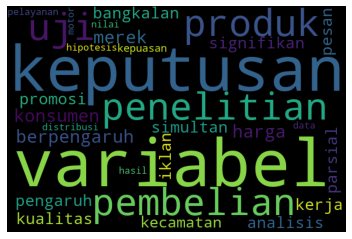

In [20]:
draw_word_cloud(0)